In [3]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


2023-10-26 12:44:58.140808: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-26 12:44:58.142062: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-26 12:44:58.162124: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-26 12:44:58.162145: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-26 12:44:58.162160: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [30]:
print(tf.config.list_physical_devices('GPU'))

[]


In [4]:
import pathlib
data_dir = "./images"
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True, cache_dir=data_dir)
data_dir = pathlib.Path(data_dir).with_suffix('')


228813984/228813984 [==============================] - 25s 0us/step


In [5]:
print(data_dir)

images


In [6]:
!mv "/home/pietro/.keras/datasets/flower_photos" "/home/pietro/Desktop/monumentor/image classification/images"

mv: cannot stat '/home/pietro/.keras/datasets/flower_photos': No such file or directory


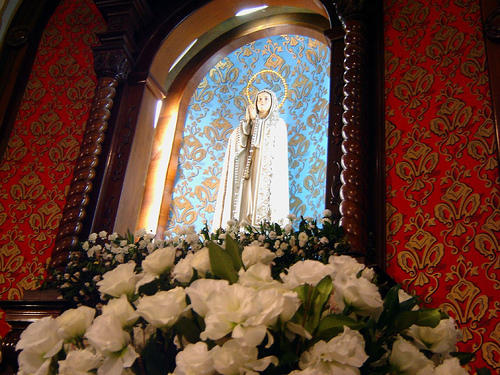

In [11]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[2]))


In [12]:
batch_size = 32
img_height = 180
img_width = 180


In [13]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)


Found 3670 files belonging to 5 classes.
Using 2936 files for training.


2023-10-26 12:51:24.248397: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-26 12:51:24.248767: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [14]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)


Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [15]:
class_names = train_ds.class_names
print(class_names)


['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


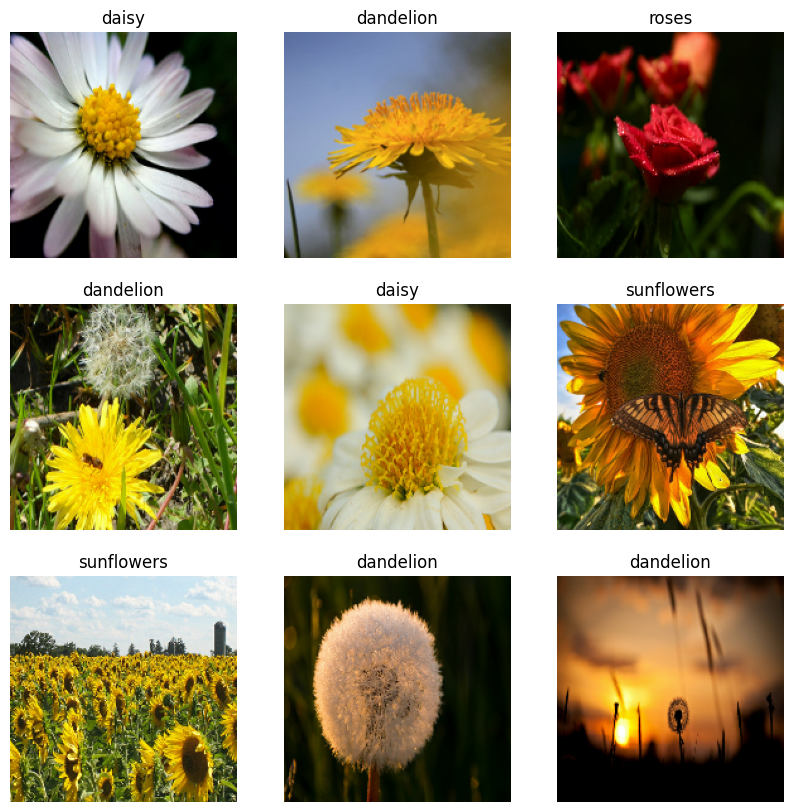

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [21]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) # chache data from the train dataset
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [20]:
normalization_layer = layers.Rescaling(1./255)


In [39]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.0 1.0


In [40]:
num_classes = len(class_names)

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal",
                        input_shape=(img_height,
                                    img_width,
                                    3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name="outputs")
])



In [43]:
model.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [44]:
epochs = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)



Epoch 1/15
92/92 [==============================] - 9s 89ms/step - loss: 1.2959 - accuracy: 0.4360 - val_loss: 1.2179 - val_accuracy: 0.5068
Epoch 2/15
92/92 [==============================] - 8s 89ms/step - loss: 1.0417 - accuracy: 0.5787 - val_loss: 0.9866 - val_accuracy: 0.6172
Epoch 3/15
92/92 [==============================] - 8s 90ms/step - loss: 0.9688 - accuracy: 0.6192 - val_loss: 0.8882 - val_accuracy: 0.6635
Epoch 4/15
92/92 [==============================] - 9s 100ms/step - loss: 0.8642 - accuracy: 0.6577 - val_loss: 0.8450 - val_accuracy: 0.6703
Epoch 5/15
92/92 [==============================] - 10s 105ms/step - loss: 0.8248 - accuracy: 0.6771 - val_loss: 0.8778 - val_accuracy: 0.6662
Epoch 6/15
92/92 [==============================] - 10s 104ms/step - loss: 0.7659 - accuracy: 0.7088 - val_loss: 0.7877 - val_accuracy: 0.6907
Epoch 7/15
92/92 [==============================] - 9s 102ms/step - loss: 0.7177 - accuracy: 0.7228 - val_loss: 0.7652 - val_accuracy: 0.6948
Epoch 8

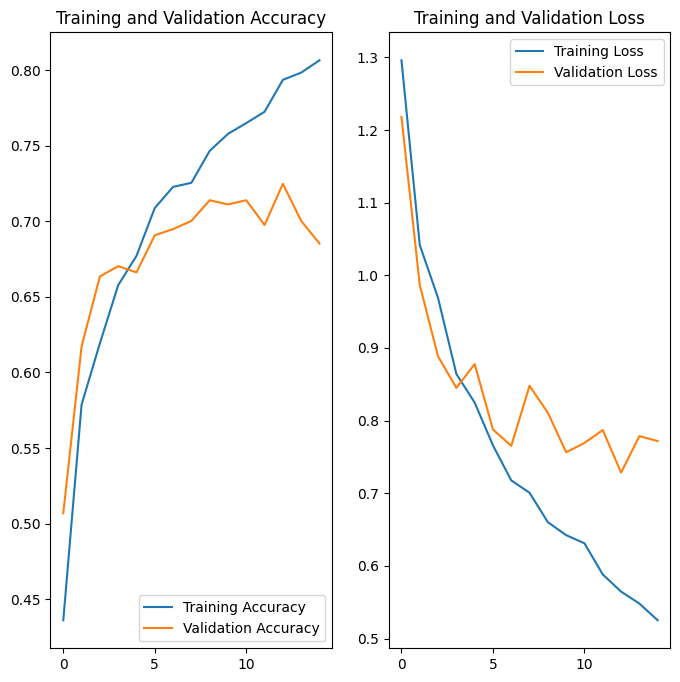

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


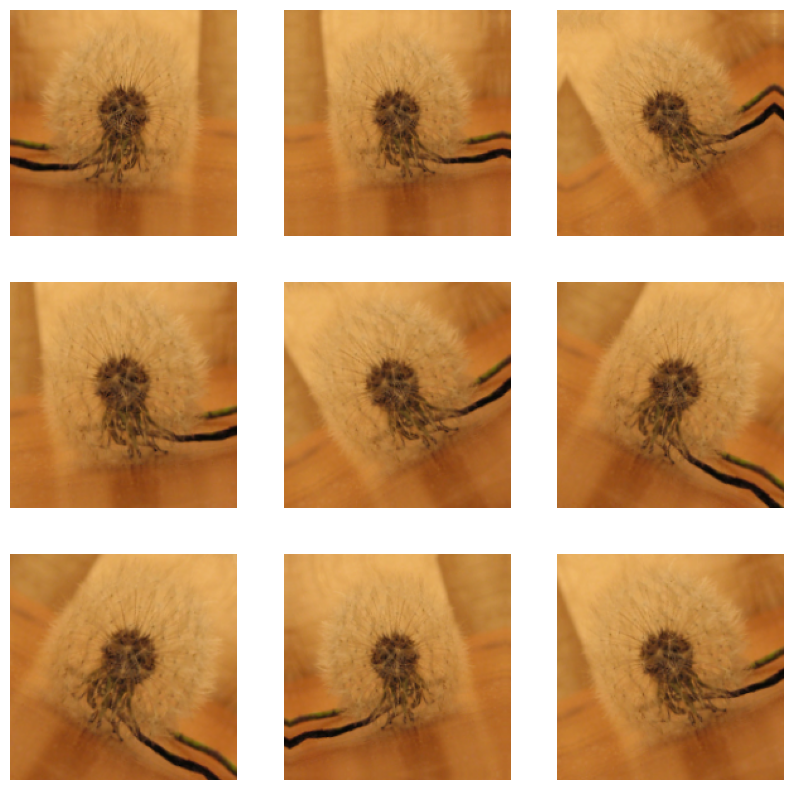

In [35]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


In [49]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


1/1 [==============================] - 0s 14ms/step
This image most likely belongs to tulips with a 44.63 percent confidence.


In [50]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: /tmp/tmp5ctfb57n/assets


INFO:tensorflow:Assets written to: /tmp/tmp5ctfb57n/assets
2023-10-26 13:32:10.424418: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-10-26 13:32:10.424435: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-10-26 13:32:10.425268: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp5ctfb57n
2023-10-26 13:32:10.426898: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-10-26 13:32:10.426905: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp5ctfb57n
2023-10-26 13:32:10.430572: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled
2023-10-26 13:32:10.431789: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-10-26 13:32:10.477517: I tensorflow/cc/saved_model/loader.cc:217] Running initializatio

In [51]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)


In [52]:
interpreter.get_signature_list()


{'serving_default': {'inputs': ['sequential_3_input'], 'outputs': ['outputs']}}

In [53]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite


In [57]:
predictions_lite = classify_lite(sequential_3_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)


This image most likely belongs to tulips with a 44.63 percent confidence.
